## Fruit Detection

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 300
CHANNELS=3
EPOCHS=25

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1147 files belonging to 6 classes.


In [4]:
class_names = dataset.class_names
class_names

['Amrapali Mango',
 'Banana Mango',
 'Fazli Mango',
 'Gopalvog Mango',
 'Langra Mango',
 'SurjoDim Mango']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 300, 300, 3)
[0 5 0 1 4 5 1 2 5 0 3 4 3 2 0 0 2 4 2 5 1 3 1 0 3 5 0 1 1 2 1 5]


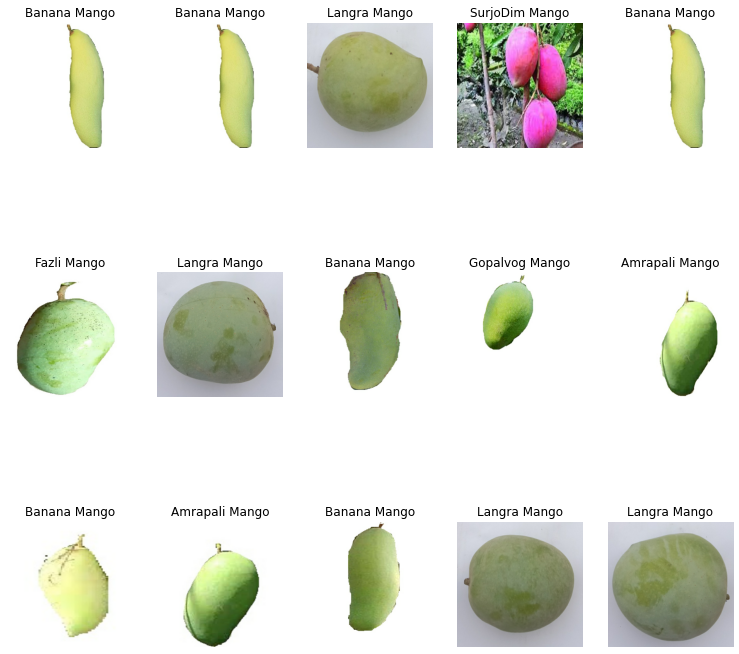

In [6]:
plt.figure(figsize=(13, 13))
for image_batch, labels_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

28

In [10]:
len(val_ds)

3

In [11]:
len(test_ds)

5

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 300, 300, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 298, 298, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 149, 149, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 147, 147, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 73, 73, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 71, 71, 64)         

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
28/28 [==============================] - 77s 2s/step - loss: 1.5574 - accuracy: 0.2835 - val_loss: 1.5495 - val_accuracy: 0.3125
Epoch 2/25
28/28 [==============================] - 71s 3s/step - loss: 1.2504 - accuracy: 0.4431 - val_loss: 1.1263 - val_accuracy: 0.3958
Epoch 3/25
28/28 [==============================] - 75s 3s/step - loss: 1.2078 - accuracy: 0.5134 - val_loss: 1.2162 - val_accuracy: 0.5417
Epoch 4/25
28/28 [==============================] - 75s 3s/step - loss: 1.1290 - accuracy: 0.5636 - val_loss: 0.9511 - val_accuracy: 0.6146
Epoch 5/25
28/28 [==============================] - 77s 3s/step - loss: 0.9865 - accuracy: 0.5904 - val_loss: 0.9763 - val_accuracy: 0.5938
Epoch 6/25
28/28 [==============================] - 71s 3s/step - loss: 0.9308 - accuracy: 0.6328 - val_loss: 0.8015 - val_accuracy: 0.6562
Epoch 7/25
28/28 [==============================] - 70s 2s/step - loss: 0.8324 - accuracy: 0.6574 - val_loss: 0.7340 - val_accuracy: 0.7083
Epoch 8/25
28/28 [==

In [20]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 4s 528ms/step - loss: 0.1454 - accuracy: 0.9625


In [21]:
scores

[0.1453738957643509, 0.9624999761581421]

In [22]:
history

In [23]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 28}

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
type(history.history['loss'])

list

In [26]:
len(history.history['loss'])

25

In [27]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.557437539100647,
 1.2504348754882812,
 1.2078497409820557,
 1.1290056705474854,
 0.9864515662193298]

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

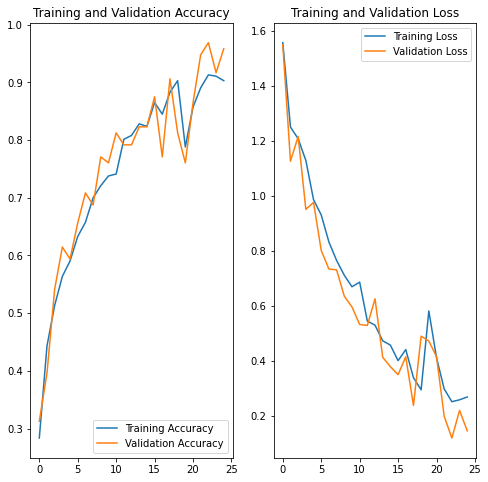

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Amrapali Mango
predicted label: Amrapali Mango


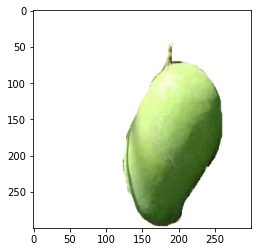

In [30]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [31]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

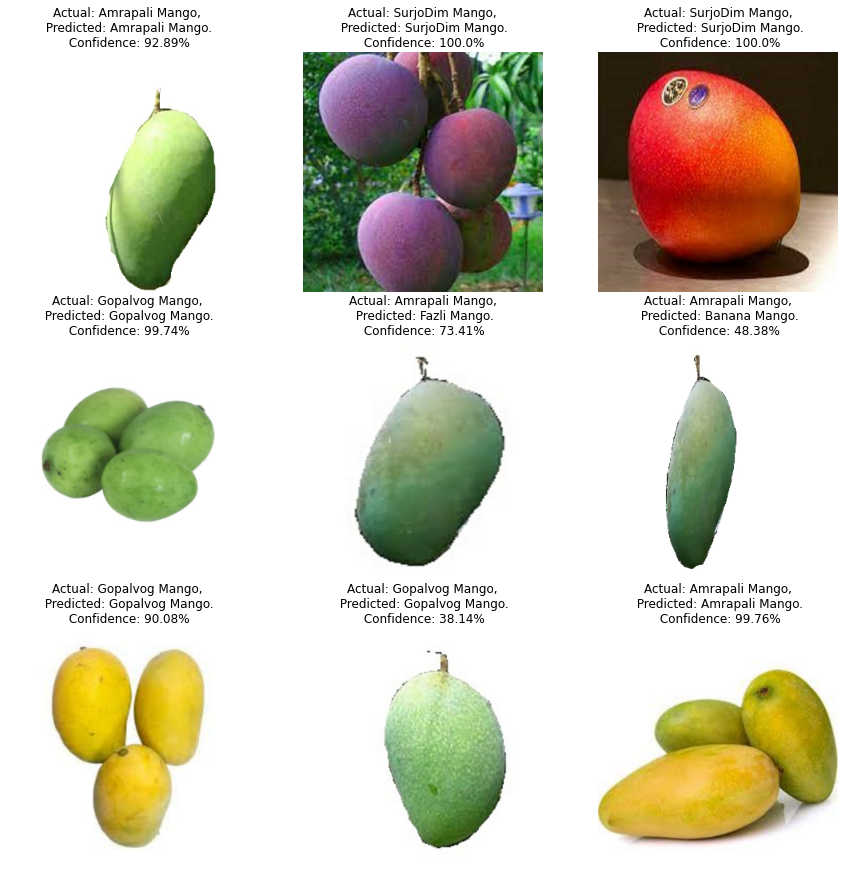

In [32]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [33]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1\assets


In [35]:
model.save("models/fruits.h5")

In [ ]:
 m, 